Loading TopicNet/20-Newsgroups dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/20NG.csv.gz:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

data/20NG_test.csv.gz:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11301 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7532 [00:00<?, ? examples/s]

Cleaned Train samples: 11083, Cleaned Test samples: 7370

Vectorizing using TF-IDF...
TF-IDF shape: (11083, 60074)

Training LinearSVC...
LinearSVC | Accuracy: 0.7088 | F1: 0.6959 | Time: 2.13s


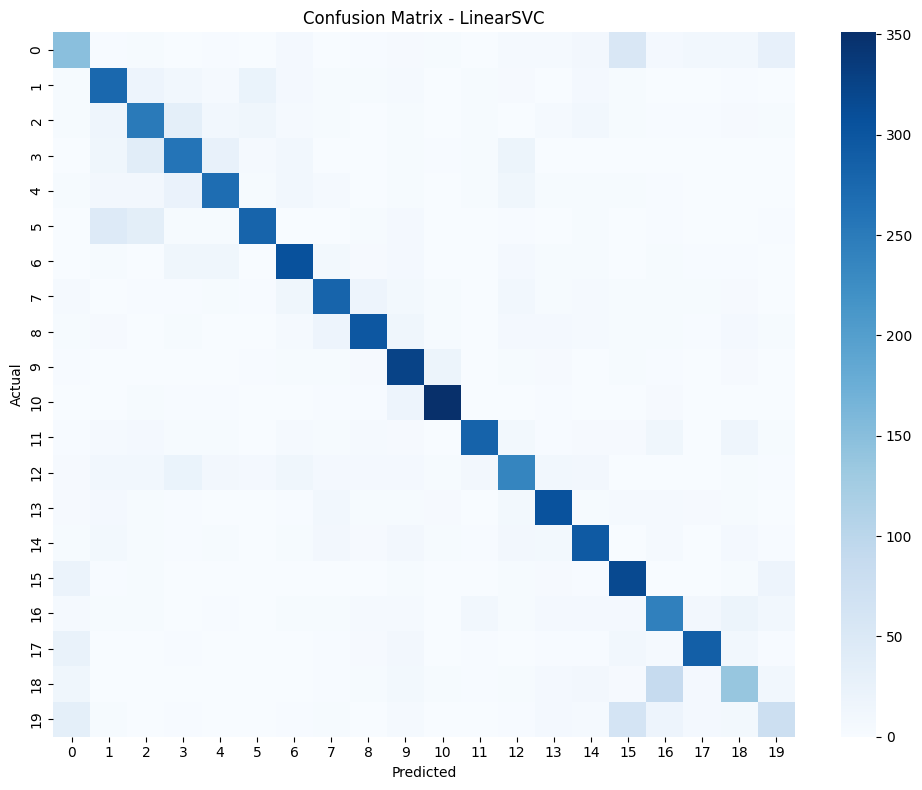


Training LogisticRegression...
LogisticRegression | Accuracy: 0.7081 | F1: 0.6902 | Time: 2.66s


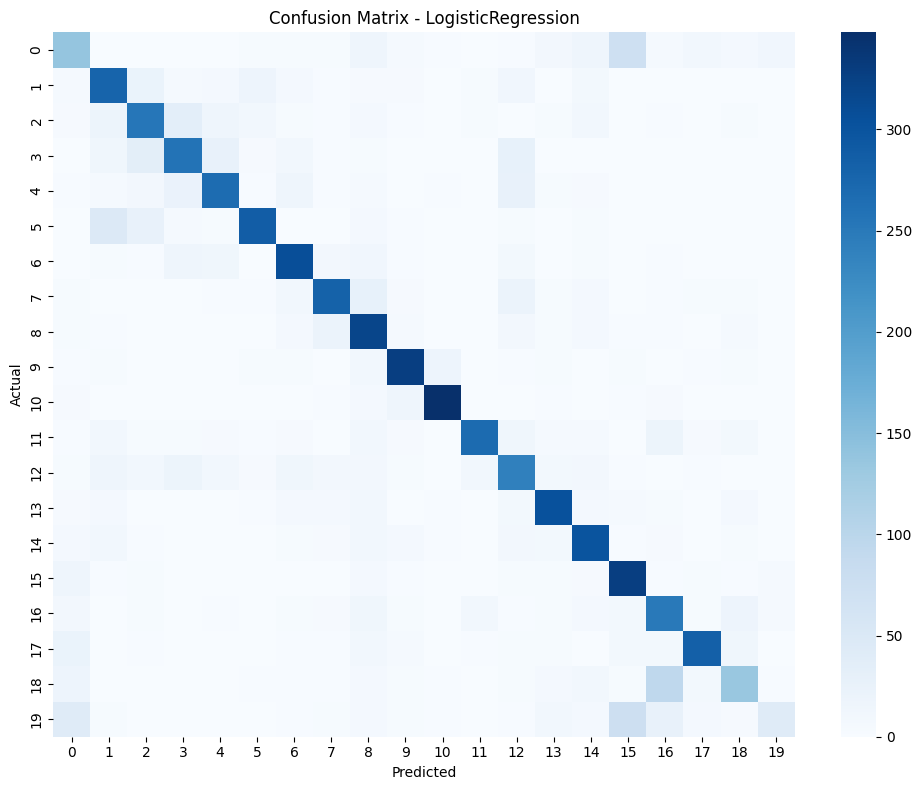


Training MultinomialNB...
MultinomialNB | Accuracy: 0.6913 | F1: 0.6616 | Time: 0.06s


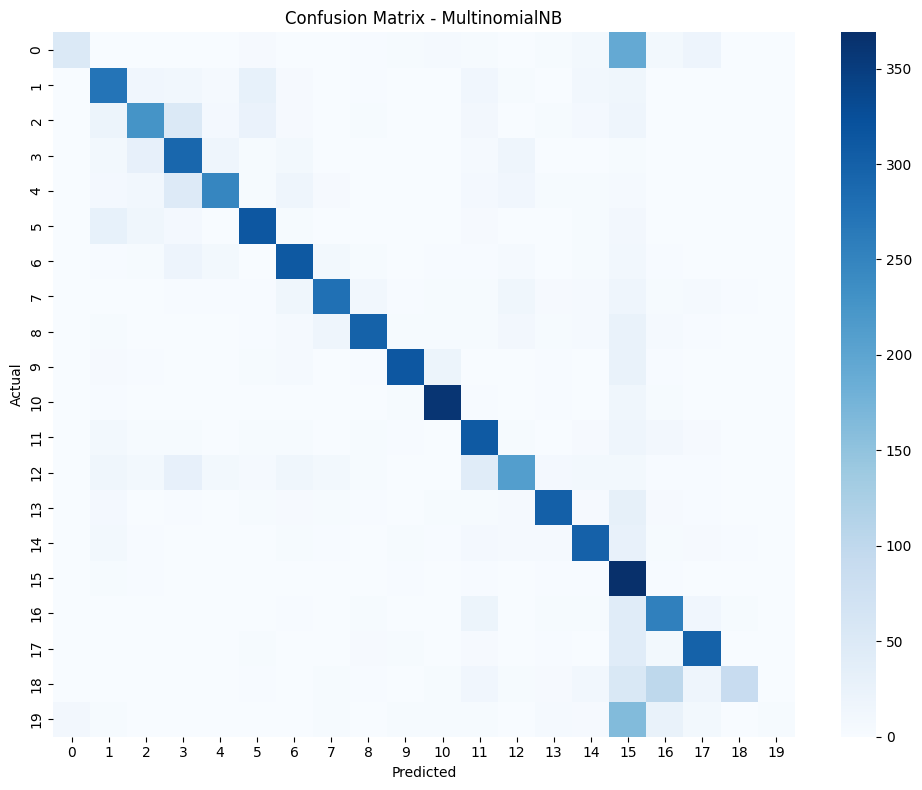


Applying TruncatedSVD (300 components)...
SVD shape: (11083, 300)

Training LinearSVC SVD-300...
LinearSVC SVD-300 | Accuracy: 0.6786 | F1: 0.6572 | Time: 8.23s


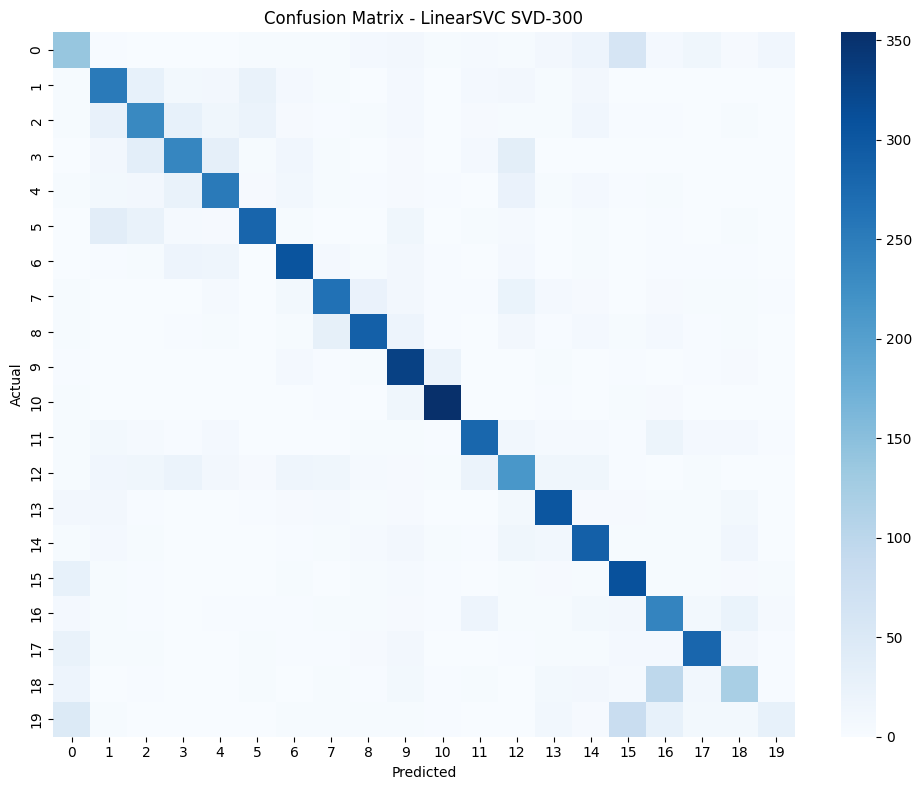


Training LogReg SVD-300...
LogReg SVD-300 | Accuracy: 0.6699 | F1: 0.6492 | Time: 4.09s


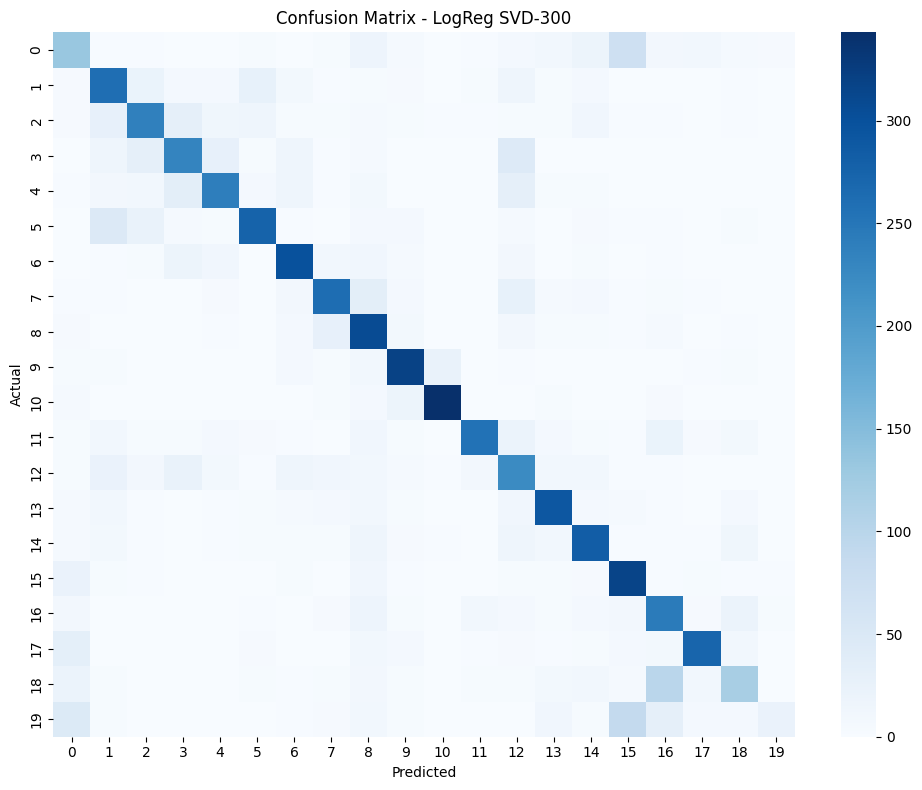


Saved: results_summary.csv
Saved model artifacts.


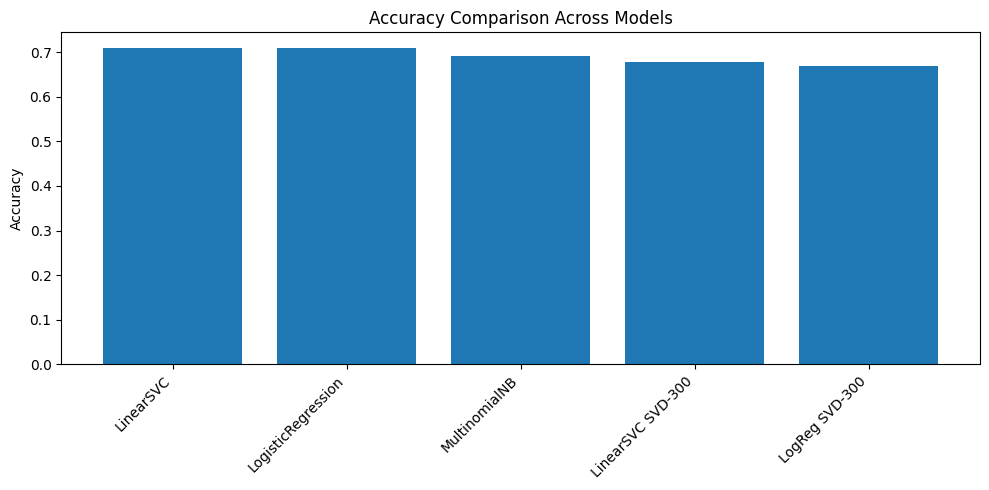

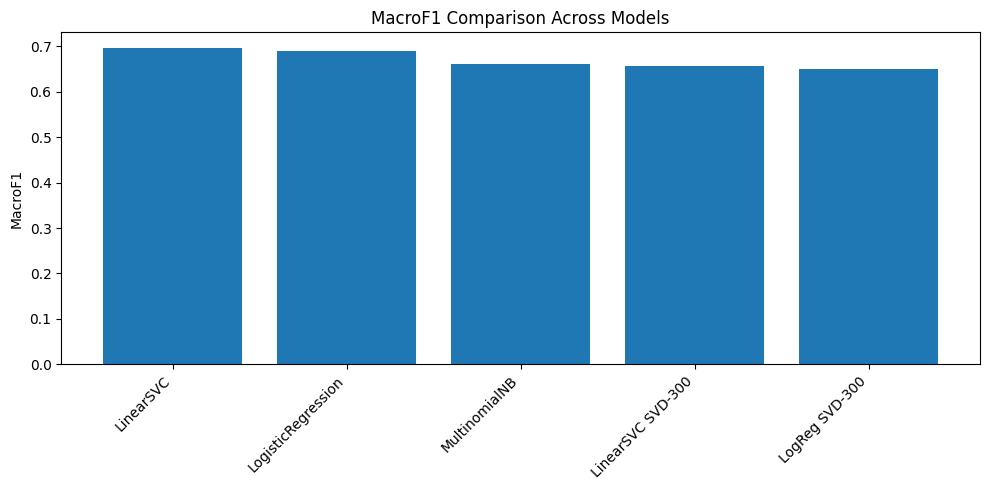

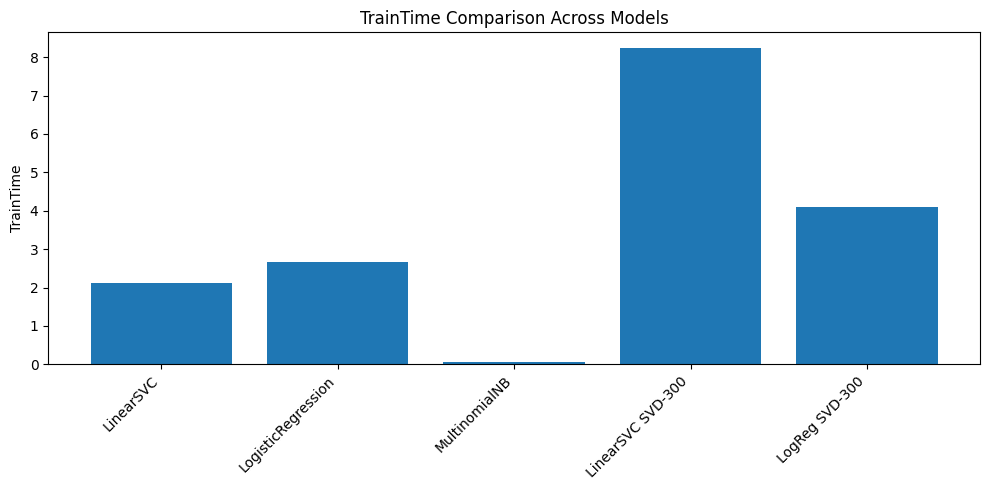

Generating PCA scatterplot...


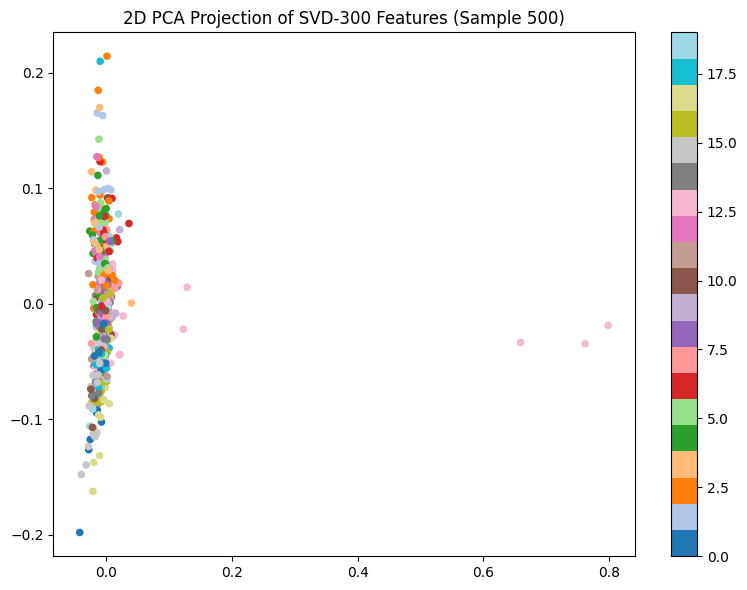


Pipeline completed successfully!


In [2]:
"""
20 Newsgroups (TopicNet/HF) - Machine Learning Pipeline
Models: LinearSVC, Logistic Regression, Multinomial NB
TF-IDF + SVD + Evaluation + Graphs
"""

# ======================================================
# IMPORT LIBRARIES
# ======================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix
)

from joblib import dump


# ======================================================
# LOAD HF DATASET (FIX MISSING TEXT)
# ======================================================
def load_data():
    print("Loading TopicNet/20-Newsgroups dataset...")
    ds = load_dataset("TopicNet/20-Newsgroups")

    text_col = "raw_text"
    label_col = "target"

    X_train_raw = ds["train"][text_col]
    y_train_raw = ds["train"][label_col]

    X_test_raw = ds["test"][text_col]
    y_test_raw = ds["test"][label_col]

    # ---------- FIX: Remove None / invalid ----------
    clean_train = [(x, y) for x, y in zip(X_train_raw, y_train_raw)
                   if x is not None and isinstance(x, str)]
    clean_test = [(x, y) for x, y in zip(X_test_raw, y_test_raw)
                  if x is not None and isinstance(x, str)]

    X_train, y_train = zip(*clean_train)
    X_test, y_test = zip(*clean_test)

    print(f"Cleaned Train samples: {len(X_train)}, Cleaned Test samples: {len(X_test)}")

    return list(X_train), list(X_test), list(y_train), list(y_test)


# ======================================================
# TF-IDF VECTORISER
# ======================================================
def build_vectorizer():
    return TfidfVectorizer(
        min_df=3,
        max_df=0.9,
        ngram_range=(1, 2),
        sublinear_tf=True,
        stop_words="english"
    )


# ======================================================
# MODEL EVALUATION
# ======================================================
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\nTraining {name}...")

    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")
    prec = precision_score(y_test, preds, average="macro")
    rec = recall_score(y_test, preds, average="macro")

    print(f"{name} | Accuracy: {acc:.4f} | F1: {f1:.4f} | Time: {train_time:.2f}s")

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", annot=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"confusion_matrix_{name}.png", dpi=200)
    plt.show()
    plt.close()

    return acc, f1, prec, rec, train_time


# ======================================================
# MAIN EXPERIMENT PIPELINE
# ======================================================
def run_experiment():

    # Load dataset
    X_train_raw, X_test_raw, y_train, y_test = load_data()

    # TF-IDF
    print("\nVectorizing using TF-IDF...")
    tfidf = build_vectorizer()
    X_train = tfidf.fit_transform(X_train_raw)
    X_test = tfidf.transform(X_test_raw)
    print("TF-IDF shape:", X_train.shape)

    # Models
    svc = LinearSVC(max_iter=5000)
    lr = LogisticRegression(max_iter=2000, solver="saga", n_jobs=-1)
    nb = MultinomialNB()

    results = []

    # ---------- Evaluate Full TF-IDF ----------
    results.append(("LinearSVC",) +
                   evaluate_model("LinearSVC", svc, X_train, y_train, X_test, y_test))

    results.append(("LogisticRegression",) +
                   evaluate_model("LogisticRegression", lr, X_train, y_train, X_test, y_test))

    results.append(("MultinomialNB",) +
                   evaluate_model("MultinomialNB", nb, X_train, y_train, X_test, y_test))

    # ======================================================
    # APPLY TRUNCATED SVD
    # ======================================================
    print("\nApplying TruncatedSVD (300 components)...")
    svd = TruncatedSVD(n_components=300, random_state=42)
    X_train_svd = svd.fit_transform(X_train)
    X_test_svd = svd.transform(X_test)
    print("SVD shape:", X_train_svd.shape)

    # ---------- Evaluate SVD Models ----------
    results.append(("LinearSVC SVD-300",) +
                   evaluate_model("LinearSVC SVD-300", svc, X_train_svd, y_train, X_test_svd, y_test))

    results.append(("LogReg SVD-300",) +
                   evaluate_model("LogReg SVD-300", lr, X_train_svd, y_train, X_test_svd, y_test))

    # Save results to CSV
    df = pd.DataFrame(results, columns=["Model", "Accuracy", "MacroF1", "Precision", "Recall", "TrainTime"])
    df.to_csv("results_summary.csv", index=False)
    print("\nSaved: results_summary.csv")

    # ======================================================
    # SAVE MODELS
    # ======================================================
    dump(svc, "model_LinearSVC.joblib")
    dump(lr, "model_LogReg.joblib")
    dump(nb, "model_NaiveBayes.joblib")
    dump(tfidf, "tfidf_vectorizer.joblib")
    dump(svd, "svd_transformer.joblib")
    print("Saved model artifacts.")

    # ======================================================
    # COMPARISON PLOTS
    # ======================================================
    metrics = ["Accuracy", "MacroF1", "TrainTime"]
    filenames = ["accuracy_comparison.png", "f1_comparison.png", "train_time_comparison.png"]

    for metric, file in zip(metrics, filenames):
        plt.figure(figsize=(10, 5))
        plt.bar(df["Model"], df[metric])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel(metric)
        plt.title(f"{metric} Comparison Across Models")
        plt.tight_layout()
        plt.savefig(file, dpi=200)
        plt.show()
        plt.close()

    # ======================================================
    # PCA SCATTERPLOT
    # ======================================================
    print("Generating PCA scatterplot...")

    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_train_svd[:500])

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                          c=y_train[:500], cmap="tab20", s=20)
    plt.colorbar(scatter)
    plt.title("2D PCA Projection of SVD-300 Features (Sample 500)")
    plt.tight_layout()
    plt.savefig("pca_scatterplot.png", dpi=200)
    plt.show()
    plt.close()

    print("\nPipeline completed successfully!")


# ======================================================
# MAIN EXECUTION
# ======================================================
if __name__ == "__main__":
    run_experiment()
